In [2]:
import numpy as np
import matplotlib.pyplot as plt 
# from PDF_Sq_silica import pdf_sq_silica
import sys 
sys.path.insert(1, '/Users/zheng/Research/my_modules')
import my_common as mc
# import os
import scipy.constants as scc
import scipy.integrate 
from scipy import optimize
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from scipy.signal import savgol_filter
from scipy.integrate import cumulative_trapezoid
plt.style.use('science')

In [3]:
def rdf_1atom_Si(box,natom,type_atom,coors,idx):
    """box,coors is in unit of nm"""
    type_atom = np.array(type_atom)
    n1 = coors[type_atom == 'Si'].shape[0]
    n2 = coors[type_atom == 'O'].shape[0]
    rcoors = np.dot(coors, np.linalg.inv(box))
    rdis = np.zeros([natom, natom, 3])
    for i in range(natom):
        tmp = rcoors[i]
        rdis[i, :, :] = tmp - rcoors
    rdis[rdis < -0.5] = rdis[rdis < -0.5] + 1
    rdis[rdis > 0.5] = rdis[rdis > 0.5] - 1
    a = np.dot(rdis[:, :, :], box)
    dis = np.sqrt((np.square(a[:, :, 0]) + np.square(a[:, :, 1]) + np.square(a[:, :, 2])))
    dis = dis *10
    delta_r = 0.1  # unit is A
#     r_max = box[0,0]/2*10
    r_max = 10
#     r = np.linspace(delta_r, r_max, int(r_max / delta_r))
    r = np.arange(delta_r, r_max, delta_r)
#     V = np.dot(np.cross(box[1, :], box[2, :]), box[0, :]) * 10 ** 3
#     rho_Si = n1 / V
#     rho_O = n2 / V
#     c = np.array([rho_Si * rho_Si, rho_Si * rho_O, rho_O * rho_O]) * V
#     g1 = np.histogram(dis[:n1, :n1], bins=r)[0] / (4 * np.pi * (r[1:] - delta_r / 2) ** 2 * delta_r * c[0])
#     g2 = np.histogram(dis[:n1, n1:], bins=r)[0] / (4 * np.pi * (r[1:] - delta_r / 2) ** 2 * delta_r * c[1])
#     g3 = np.histogram(dis[n1:, n1:], bins=r)[0] / (4 * np.pi * (r[1:] - delta_r / 2) ** 2 * delta_r * c[2])
#     g1 = np.histogram(dis[:n1, :n1], bins=r)[0]/2  # Si-Si
#     g2 = np.histogram(dis[:n1, n1:], bins=r)[0] 
#     g3 = np.histogram(dis[n1:, n1:], bins=r)[0]/2  # O-O
    g1 = np.histogram(dis[idx, :n1], bins=r)[0]  # Si-Si
    g2 = np.histogram(dis[idx, n1:], bins=r)[0]    # Si-O
#     g3 = np.histogram(dis[n1:, n1:], bins=r)[0]/2  # O-O
    R = r[1:] - delta_r / 2
    
    return R,g1,g2

In [4]:
delta_r = 0.02  # unit is A
#     r_max = box[0,0]/2*10
r_max = 10
#     r = np.linspace(delta_r, r_max, int(r_max / delta_r))
r = np.arange(delta_r, r_max, delta_r)
R = r[1:] - delta_r / 2

In [5]:
def collect_one_folder_v2(folder_name,sf=0,ef=1,delta_r=0.02):
    
    
    natom=450
    type_atom =[]
    for i in range(int(natom/3)):
        type_atom.append('Si')
    for i in range(int(natom/3)*2):
        type_atom.append('O') 
    
    # this is for DFT collect coors

    natom = 450
    #step 1: read file
    fxml=open('{}/vasprun.xml'.format(folder_name))  # choose new xml file 
    lines = fxml.readlines()
    fxml.close()

    n=0
    coors_list=[]
    forces_list=[]
    e_list=[]
    box=np.zeros([3,3])

    for l in range(len(lines)):
        if (box[0,0]==0) and (lines[l]=='   <varray name="basis" >\n'):
            for la in range(3):
                box[la,:]=np.array([float(it) for it in lines[l+la+1].split()[1:4]])
        if lines[l]=='   <varray name="positions" >\n':
            n=n+1
            coors=np.zeros([natom,3])
            for la in range(natom):
                coors[la,:]=np.array([float(it) for it in lines[l+la+1].split()[1:4]])
            coors_list.append(coors)

        if lines[l]=='  <varray name="forces" >\n':
            forces=np.zeros([natom,3])
            for la in range(natom):
                forces[la,:]=np.array([float(it) for it in lines[l+la+1].split()[1:4]])
            forces_list.append(forces)

        if '<i name="total">' in lines[l]:
            e_list.append(float(lines[l-6].split()[2]))

    print(n,' frames in total')
    e_all = np.array(e_list)

    box = box/10

    # for Si
    type_atom = np.array(type_atom)
    n1 = np.sum(type_atom == 'Si')
    n2 = np.sum(type_atom == 'O')

    # delta_r = 0.04  # unit is A
    #     r_max = box[0,0]/2*10
    r_max = 10
    #     r = np.linspace(delta_r, r_max, int(r_max / delta_r))
    r = np.arange(delta_r, r_max, delta_r)
    R = r[1:] - delta_r / 2

    # for Si , y
    if 'y_force' in locals():
        del y_force

    for i in range(sf,ef):
        if 'y_force' in locals():
            y_force = np.concatenate((y_force,np.concatenate(forces_list[i][:n1])))
        else:
            y_force = np.concatenate(forces_list[i][:n1])

    if 'X' in locals():
        del X

    for i in range(sf,ef):

        coors=(coors_list[i] @ box)
        rcoors = coors_list[i]
        rdis = np.zeros([natom, natom, 3])
        for i in range(natom):
            tmp = rcoors[i]
            rdis[i, :, :] = tmp - rcoors
        rdis[rdis < -0.5] = rdis[rdis < -0.5] + 1
        rdis[rdis > 0.5] = rdis[rdis > 0.5] - 1
        a = np.dot(rdis[:, :, :], box)
        dis = np.sqrt((np.square(a[:, :, 0]) + np.square(a[:, :, 1]) + np.square(a[:, :, 2])))
        dis = dis *10

        for idx in range(n1):

            # nSi_Si = []
            # vector_list = []
            g1_n = np.zeros([3,len(r)-1])
            g2_n = np.zeros([3,len(r)-1])

            # Si-Si
            n_tmp_list = []
            for idr in range(len(r)-1): 
                n_tmp = np.sum((dis[idx, :n1]>=r[idr]) & (dis[idx, :n1]<r[idr+1])) # Si-Si
                n_tmp_list.append(n_tmp)
                if n_tmp >0:
                    id_tmp = np.argwhere((dis[idx, :n1]>=r[idr]) & (dis[idx, :n1]<r[idr+1]))
                    v_tmp = coors[id_tmp,:] - coors[idx,:]
                    v_tmp[v_tmp>box[0,0]/2] = v_tmp[v_tmp>box[0,0]/2] - box[0,0]
                    v_tmp[v_tmp<-box[0,0]/2] = v_tmp[v_tmp<-box[0,0]/2] + box[0,0]
                    vn = 20*v_tmp/(r[idr]+r[idr+1])
                    vu = np.sum(vn,axis=0)
            #         vector_list.append(vu)
                    g1_n[:,idr]= -vu

            # Si-O
            for idr in range(len(r)-1): 
                n_tmp = np.sum((dis[idx, n1:]>=r[idr]) & (dis[idx, n1:]<r[idr+1])) # Si-O
                if n_tmp >0:
                    id_tmp = np.argwhere((dis[idx, n1:]>=r[idr]) & (dis[idx, n1:]<r[idr+1]))
                    id_tmp = id_tmp + n1
                    v_tmp = coors[id_tmp,:] - coors[idx,:]
                    v_tmp[v_tmp>box[0,0]/2] = v_tmp[v_tmp>box[0,0]/2] - box[0,0]
                    v_tmp[v_tmp<-box[0,0]/2] = v_tmp[v_tmp<-box[0,0]/2] + box[0,0]
                    vn = 20*v_tmp/(r[idr]+r[idr+1])
                    vu = np.sum(vn,axis=0)
            #         vector_list.append(vu)
                    g2_n[:,idr]= -vu

            if 'X' in locals():
                X = np.vstack((X,np.concatenate((g1_n,g2_n),axis=1)))
            else:
                X = np.concatenate((g1_n,g2_n),axis=1)

    # np.savez('force_fitting',y_force1 = y_force, X1 = X)

    # for O, 

    type_atom = np.array(type_atom)
    n1 = coors[type_atom == 'Si'].shape[0]
    n2 = coors[type_atom == 'O'].shape[0]

#     delta_r = 0.02  # unit is A
#     #     r_max = box[0,0]/2*10
#     r_max = 10
#     #     r = np.linspace(delta_r, r_max, int(r_max / delta_r))
#     r = np.arange(delta_r, r_max, delta_r)
#     R = r[1:] - delta_r / 2

    if 'y_force2' in locals():
        del y_force2

    for i in range(sf,ef):
        if 'y_force2' in locals():
            y_force2 = np.concatenate((y_force2,np.concatenate(forces_list[i][n1:])))
        else:
            y_force2 = np.concatenate(forces_list[i][n1:])

    if 'X2' in locals():
        del X2

    for i in range(sf,ef):

        coors=(coors_list[i] @ box)
        rcoors = coors_list[i]
        rdis = np.zeros([natom, natom, 3])
        for i in range(natom):
            tmp = rcoors[i]
            rdis[i, :, :] = tmp - rcoors
        rdis[rdis < -0.5] = rdis[rdis < -0.5] + 1
        rdis[rdis > 0.5] = rdis[rdis > 0.5] - 1
        a = np.dot(rdis[:, :, :], box)
        dis = np.sqrt((np.square(a[:, :, 0]) + np.square(a[:, :, 1]) + np.square(a[:, :, 2])))
        dis = dis *10

        for idx1 in range(n2):

            idx = idx1+n1

            # vector_list = []
            g1_n = np.zeros([3,len(r)-1])
            g2_n = np.zeros([3,len(r)-1])

            # O-Si
            for idr in range(len(r)-1): 
                n_tmp = np.sum((dis[idx, :n1]>=r[idr]) & (dis[idx, :n1]<r[idr+1])) # Si-Si
                if n_tmp >0:
                    id_tmp = np.argwhere((dis[idx, :n1]>=r[idr]) & (dis[idx, :n1]<r[idr+1]))
                    v_tmp = coors[id_tmp,:] - coors[idx,:]
                    v_tmp[v_tmp>box[0,0]/2] = v_tmp[v_tmp>box[0,0]/2] - box[0,0]
                    v_tmp[v_tmp<-box[0,0]/2] = v_tmp[v_tmp<-box[0,0]/2] + box[0,0]
                    vn = 20*v_tmp/(r[idr]+r[idr+1])
                    vu = np.sum(vn,axis=0)
            #         vector_list.append(vu)
                    g1_n[:,idr]= -vu

            # O-O
            for idr in range(len(r)-1): 
                n_tmp = np.sum((dis[idx, n1:]>=r[idr]) & (dis[idx, n1:]<r[idr+1])) # Si-O
                if n_tmp >0:
                    id_tmp = np.argwhere((dis[idx, n1:]>=r[idr]) & (dis[idx, n1:]<r[idr+1]))
                    id_tmp = id_tmp + n1
                    v_tmp = coors[id_tmp,:] - coors[idx,:]
                    v_tmp[v_tmp>box[0,0]/2] = v_tmp[v_tmp>box[0,0]/2] - box[0,0]
                    v_tmp[v_tmp<-box[0,0]/2] = v_tmp[v_tmp<-box[0,0]/2] + box[0,0]
                    vn = 20*v_tmp/(r[idr]+r[idr+1])
                    vu = np.sum(vn,axis=0)
            #         vector_list.append(vu)
                    g2_n[:,idr]= -vu

            if 'X2' in locals():
                X2 = np.vstack((X2,np.concatenate((g1_n,g2_n),axis=1)))
            else:
                X2 = np.concatenate((g1_n,g2_n),axis=1)
    
    return X,y_force,X2,y_force2
    # np.savez('force_fitting2',y_force2 = y_force2, X2 = X2)

In [75]:
X,y_force,X2,y_force2 = collect_one_folder_v2('../run14',300,400,0.1)

875  frames in total


In [34]:
X,y_force,X2,y_force2 = result_0d1

In [76]:
result_0d1 = [X,y_force,X2,y_force2]

In [35]:
X.shape

(45000, 996)

In [ ]:
np.savez('force_fitting_0211_d1d5',y_force=y_force,X=X,y_force2 = y_force2, X2 = X2)


In [6]:
y_force = np.load('../force_fitting_01062022_c10.npz')['y_force']
X = np.load('../force_fitting_01062022_c10.npz')['X']
y_force2 = np.load('../force_fitting_01062022_c10.npz')['y_force2']
X2 = np.load('../force_fitting_01062022_c10.npz')['X2']

In [7]:
y_force2.shape

(90000,)

In [8]:
X = np.hstack((X[:,np.argwhere(R[R<8])[:,0]],X[:,len(R)+np.argwhere(R[R<8])[:,0]]))
X2 = np.hstack((X2[:,np.argwhere(R[R<8])[:,0]],X2[:,len(R)+np.argwhere(R[R<8])[:,0]]))

In [77]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_force,random_state=1,test_size=0.2)
model_ridge = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,
                                   alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])) # alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
model_ridge.fit(Xtrain,ytrain)
# model_lasso = linear_model.LassoCV(cv=10,fit_intercept=True,normalize=False)
print(model_ridge.score(Xtest,ytest))
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y_force2,random_state=1,test_size=0.2)
model_ridge2 = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,) # ,alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
model_ridge2.fit(Xtrain2,ytrain2)
print(model_ridge2.score(Xtrain2,ytrain2))

0.8545896125092738
0.8933688890513627


## How does the cutoff distance influence the force matching?

In [14]:
cutoff_select = np.arange(2,9.1,1)

In [15]:
accuracy_cut_list = []

for i in range(len(cutoff_select)):
    idx_R = np.concatenate((np.argwhere(R<cutoff_select[i])[:,0],np.argwhere(R<cutoff_select[i])[:,0]+int(R.shape[0]/2)))
    X_cut = X[:,idx_R]
    X2_cut = X2[:,idx_R]

    tmp1 = []
    tmp2 = []
    for j in range(3):
        Xtrain, Xtest, ytrain, ytest = train_test_split(X_cut, y_force,test_size=0.2)
        model_ridge = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,
                                        alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])) # alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
        model_ridge.fit(Xtrain,ytrain)
        # model_lasso = linear_model.LassoCV(cv=10,fit_intercept=True,normalize=False)
        tmp1.append(model_ridge.score(Xtest,ytest))

        Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2_cut, y_force2,test_size=0.2)
        model_ridge2 = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,) # ,alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
        model_ridge2.fit(Xtrain2,ytrain2)
        tmp2.append(model_ridge2.score(Xtrain2,ytrain2))
    tmp1 = np.mean(tmp1)
    tmp2 = np.mean(tmp2)
    accuracy_cut_list.append([tmp1,tmp2])

In [15]:
# accuracy_cut_list_45 = accuracy_cut_list

In [18]:
accuracy_cut_list_45 

[[0.12094209316848618, 0.6666012001115128],
 [0.12991161996275838, 0.6696814628090584]]

In [10]:
accuracy_cut_list_28 = accuracy_cut_list

In [8]:
accuracy_cut_list = np.vstack(accuracy_cut_list)

In [1]:
plt.figure(figsize=[3+3/8,2.4],dpi=600)
plt.plot(cutoff_select, accuracy_cut_list[:,0],'-ko',label='Si')
plt.plot(cutoff_select, accuracy_cut_list[:,1],'-s',label='O')
plt.legend(frameon=False,loc=4)
plt.xlabel('Cutoff distance ($\mathrm{\AA}$)')
plt.ylabel('R2 of test data')
# plt.savefig('cutoff.pdf')

NameError: name 'plt' is not defined

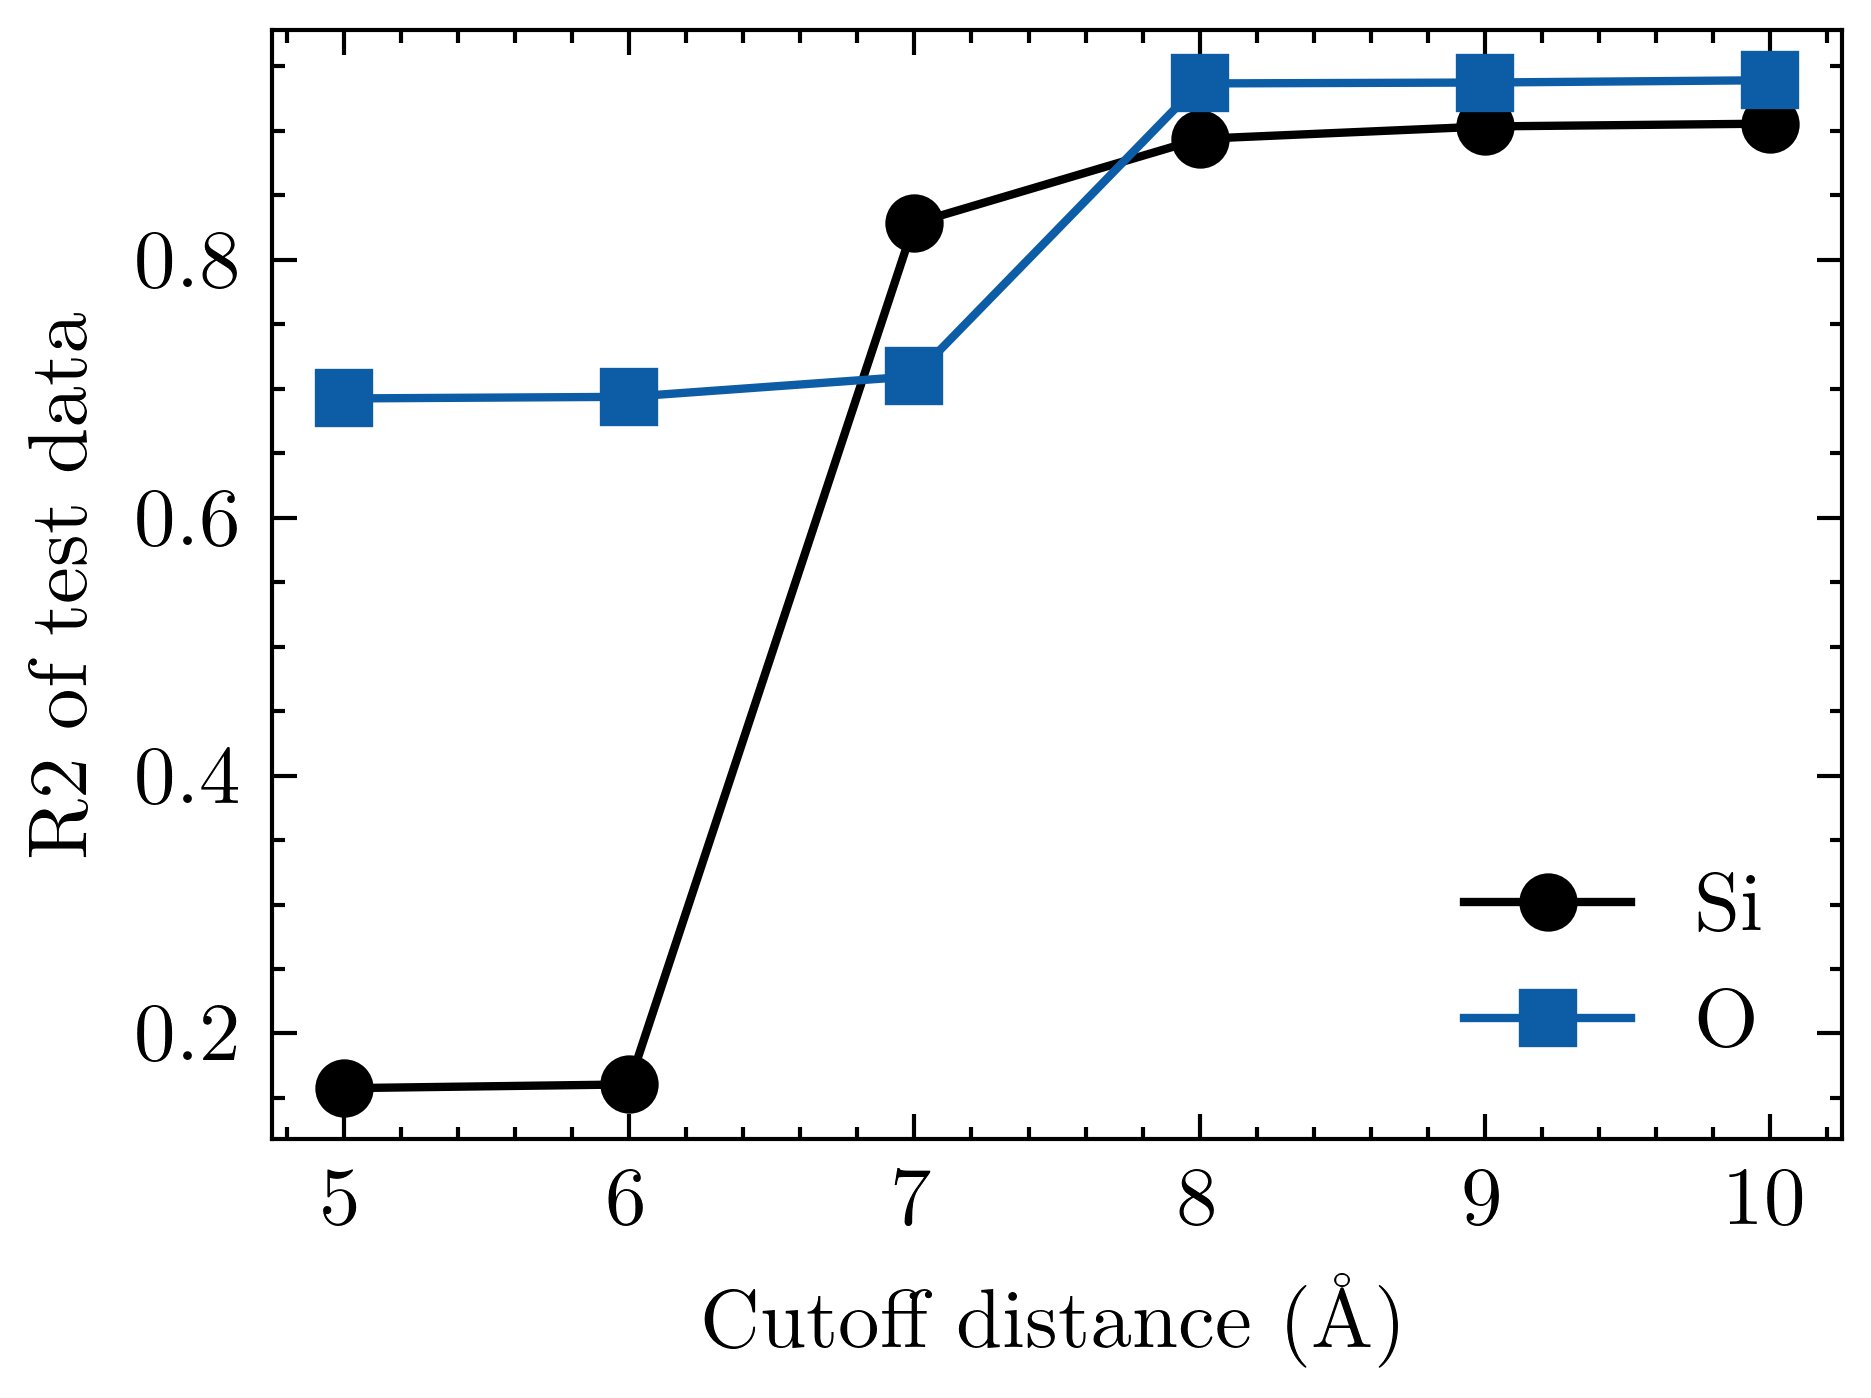

In [74]:
plt.figure(figsize=[3+3/8,2.4],dpi=600)
plt.plot(cutoff_select, accuracy_cut_list[:,0],'-ko',label='Si')
plt.plot(cutoff_select, accuracy_cut_list[:,1],'-s',label='O')
plt.legend(frameon=False,loc=4)
plt.xlabel('Cutoff distance ($\mathrm{\AA}$)')
plt.ylabel('R2 of test data')
plt.savefig('cutoff.pdf')

## Performance 

1.2896041736263653
0.5200447356924277


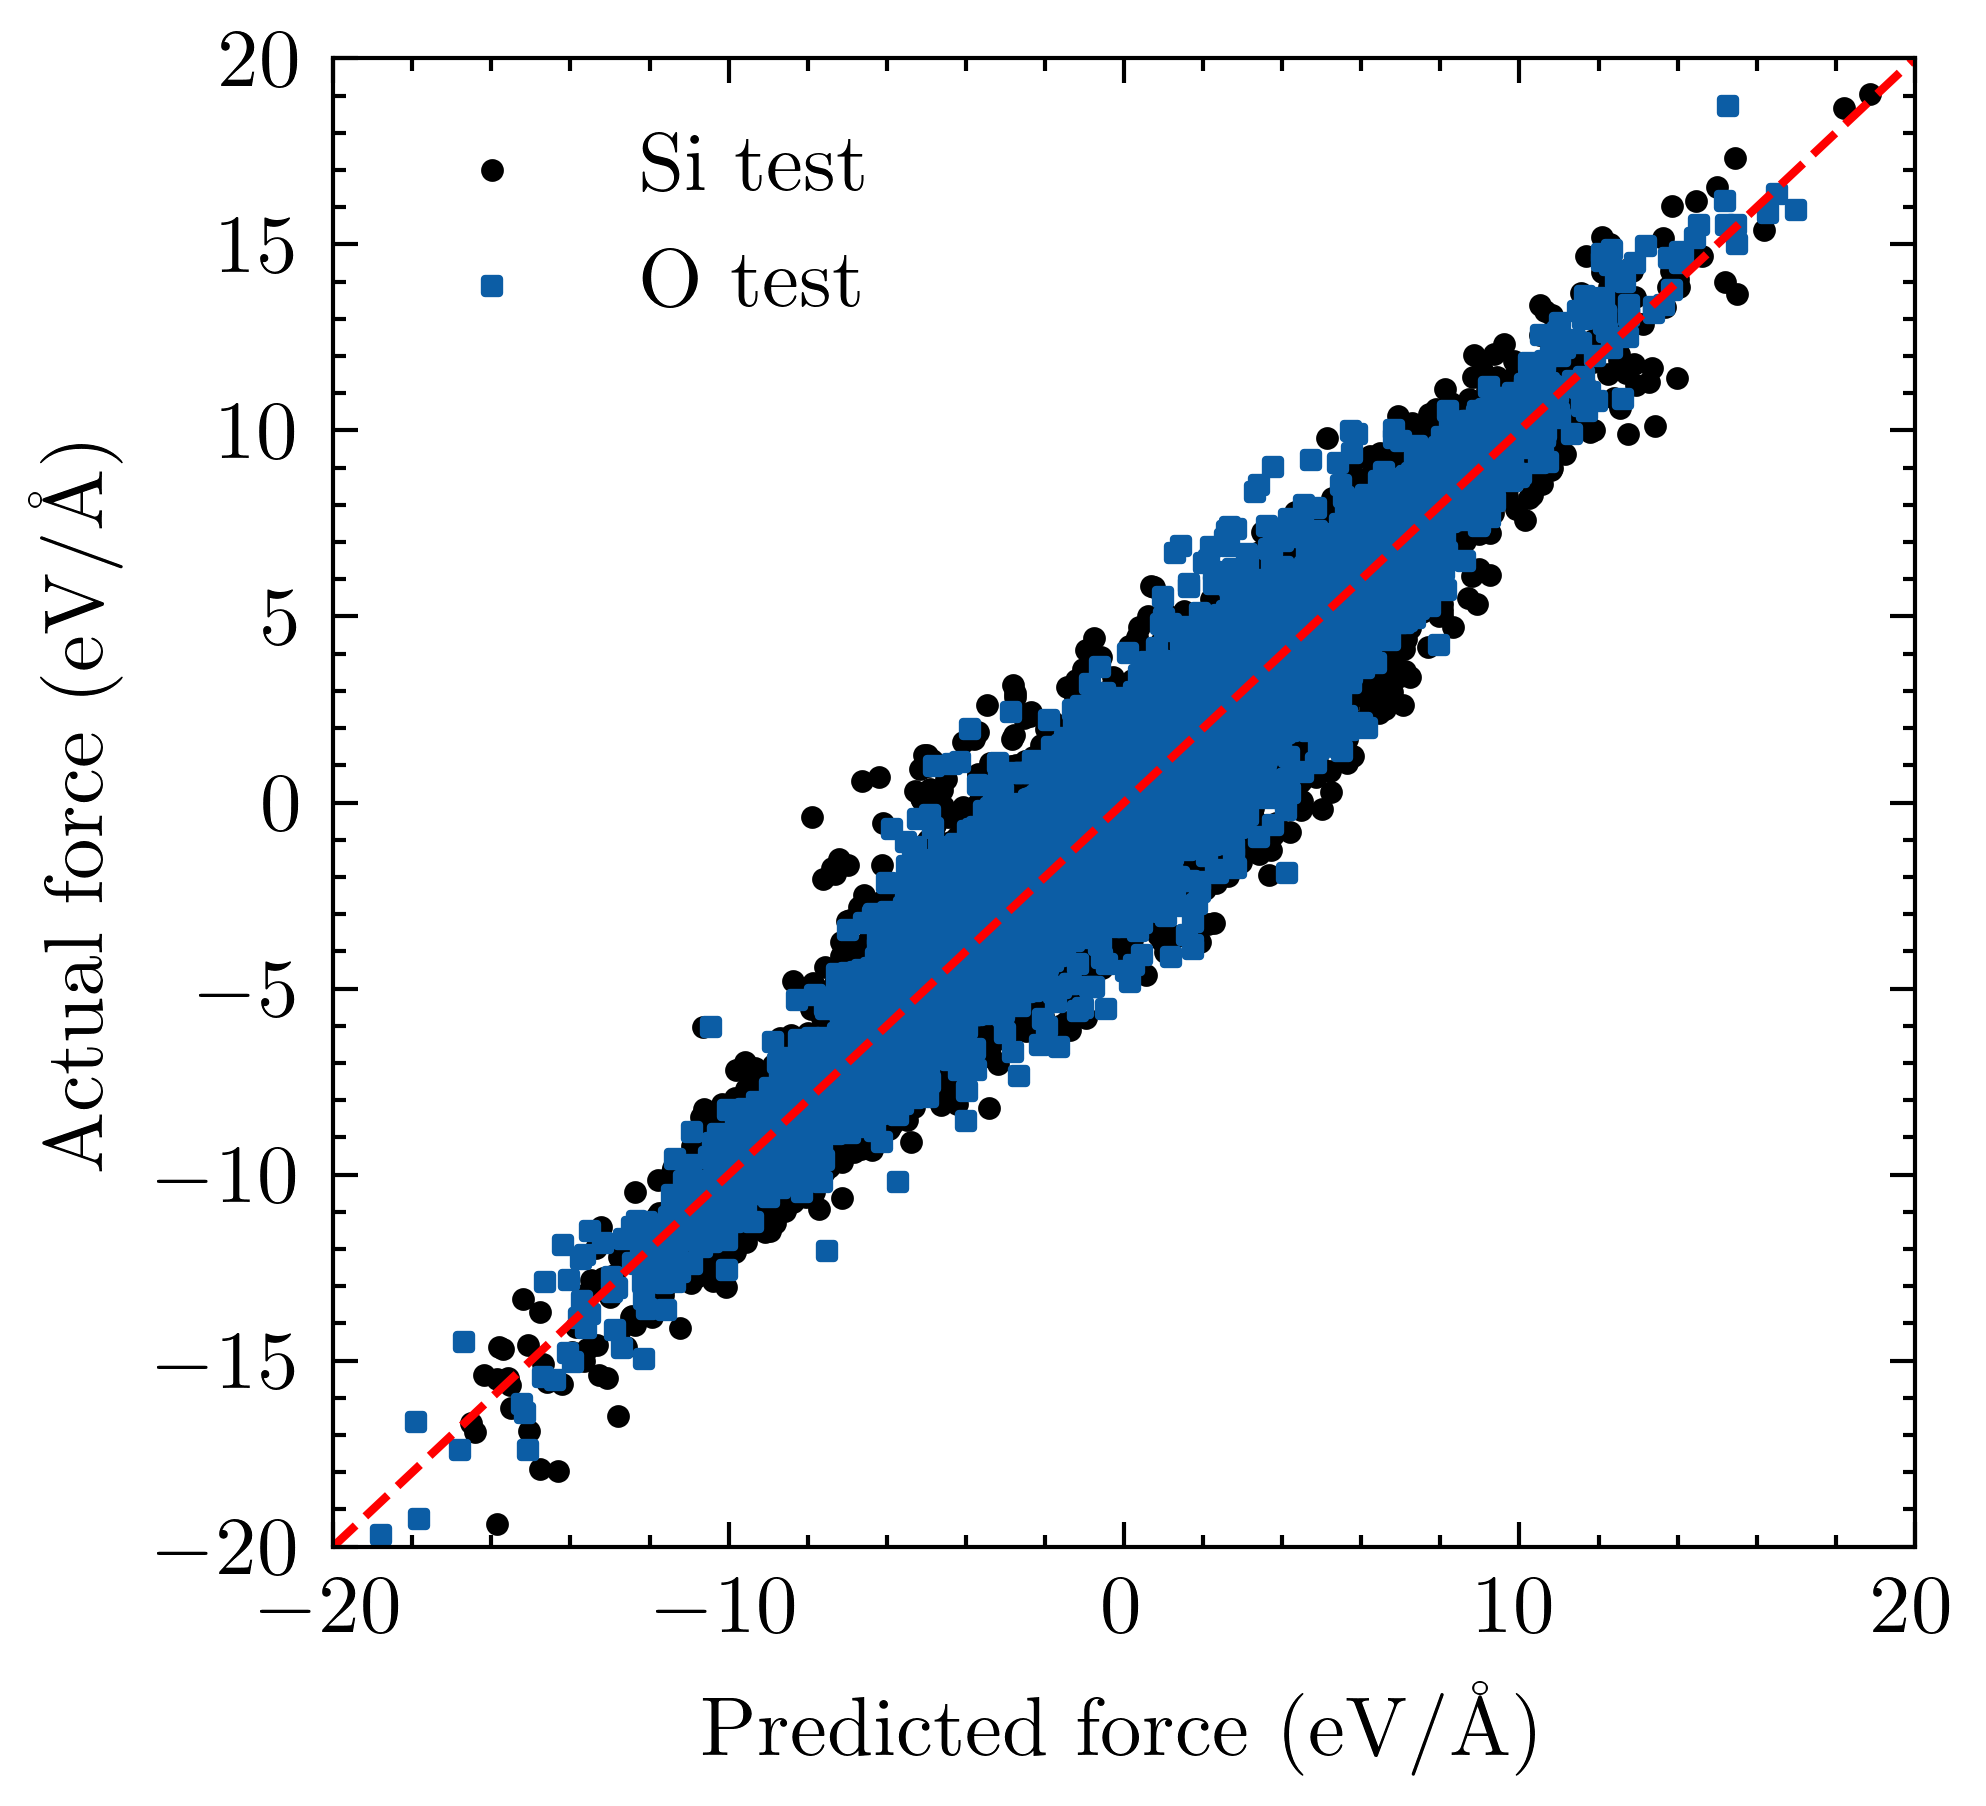

In [37]:
plt.figure(figsize=[3.3,3],dpi=600)

plt.scatter(model_ridge.predict(Xtest),ytest,3,facecolors='k',ec='k',label='Si test')
plt.scatter(model_ridge2.predict(Xtest2),ytest2,3,marker='s',facecolors='C0',ec='C0',label='O test')
plt.plot([-20,20],[-20,20],'r--')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.legend()
plt.tight_layout()
plt.xlabel('Predicted force (eV/$\mathrm{\AA}$)')
plt.ylabel('Actual force (eV/$\mathrm{\AA}$)')
# plt.savefig('/Volumes/GoogleDrive/My Drive/Research/silica_potential_AIMD/figures/performance.pdf')
MSE1 = np.sum((ytest-model_ridge.predict(Xtest))**2)/len(ytest)
MSE2 = np.sum((ytest2-model_ridge2.predict(Xtest2))**2)/len(ytest2)
print(MSE1)
print(MSE2)
w1 = 1/MSE1
w2 = 1/MSE2
# # re-training Si model with fixed SiO interaction 
# y_force1 = y_force-X[:,int(Xtrain2.shape[1]/2):]@model_ridge2.coef_[:int(Xtrain2.shape[1]/2)]
# X1 = X[:,:int(Xtrain2.shape[1]/2)]

# Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X1, y_force1,random_state=10,test_size=0.2)
# model_ridge1 = linear_model.RidgeCV(cv=5,fit_intercept=False,normalize=False,
#                                    alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1]))
# model_ridge1.fit(Xtrain1,ytrain1)

# print(np.sum((ytest1-model_ridge1.predict(Xtest1))**2)/len(ytest1))

In [5]:
# training together all the pairs
y_force3 = y_force+y_force2[:len(y_force)]
y_force3 = np.concatenate((y_force3,y_force-y_force2[:len(y_force)]))

In [6]:
nrange = int(X.shape[1]/2)

In [7]:
X3 = np.hstack((X[:,:nrange],X[:,nrange:]+X2[:len(y_force),:nrange],X2[:len(y_force),nrange:]))
X3 = np.vstack((X3,np.hstack((X[:,:nrange],X[:,nrange:]-X2[:len(y_force),:nrange],-X2[:len(y_force),nrange:]))))

In [8]:
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(X3, y_force3,random_state=10,test_size=0.2)
model_ridge3 = linear_model.RidgeCV(cv=5,fit_intercept=False,normalize=False,
                                   alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1]))
model_ridge3.fit(Xtrain3,ytrain3)
print(np.sum((ytest3-model_ridge3.predict(Xtest3))**2)/len(ytest3))

1.9210829607969075


In [27]:
model_ridge3.alpha_

1e-08

In [13]:
model_linear = linear_model.LinearRegression()
model_linear.fit(Xtrain3,ytrain3)
print(np.sum((ytest3-model_linear.predict(Xtest3))**2)/len(ytest3))

1.9256211790789635


In [56]:
# plot: error vs. training data size for both training and testing error
model_ridge3_tmp = linear_model.RidgeCV(cv=5,fit_intercept=False,normalize=False)
trainingsize = np.int_(np.logspace(1,np.log10(len(ytrain3)),20))
result = []

for itsize in trainingsize:
    if itsize<100000:
        train_e_tmp=[]
        test_e_tmp=[]
        for irandom in range(5):
            id_choose = np.random.choice(np.arange(len(ytrain3)),itsize)
            model_ridge3_tmp.fit(Xtrain3[id_choose,:],ytrain3[id_choose])
            train_e_tmp.append(np.sum((ytrain3[id_choose]-model_ridge3_tmp.predict(Xtrain3[id_choose,:]))**2)/len(id_choose))
            test_e_tmp.append(np.sum((ytest3-model_ridge3_tmp.predict(Xtest3))**2)/len(ytest3))
        train_e = np.mean(train_e_tmp)
        test_e = np.mean(test_e_tmp)
    else:
        id_choose = np.random.choice(np.arange(len(ytrain3)),itsize)
        model_ridge3_tmp.fit(Xtrain3[id_choose,:],ytrain3[id_choose])
        train_e = np.sum((ytrain3[id_choose]-model_ridge3_tmp.predict(Xtrain3[id_choose,:]))**2)/len(id_choose)
        test_e = np.sum((ytest3-model_ridge3_tmp.predict(Xtest3))**2)/len(ytest3)
    result.append([train_e,test_e])
    

result = np.array(result)

plt.figure(dpi=600)
plt.loglog(trainingsize,result[:,0],'-o',label='training')
plt.plot(trainingsize,result[:,1],'-o',label='testing')
plt.legend()
plt.ylabel('MSE (eV$^2$/\AA$^2$)')
plt.xlabel('Training data size')
# plt.savefig('error_size.pdf')

Text(12.468293811401683, 0.5, 'DFT force (eV/$\\mathrm{\\AA}$)')

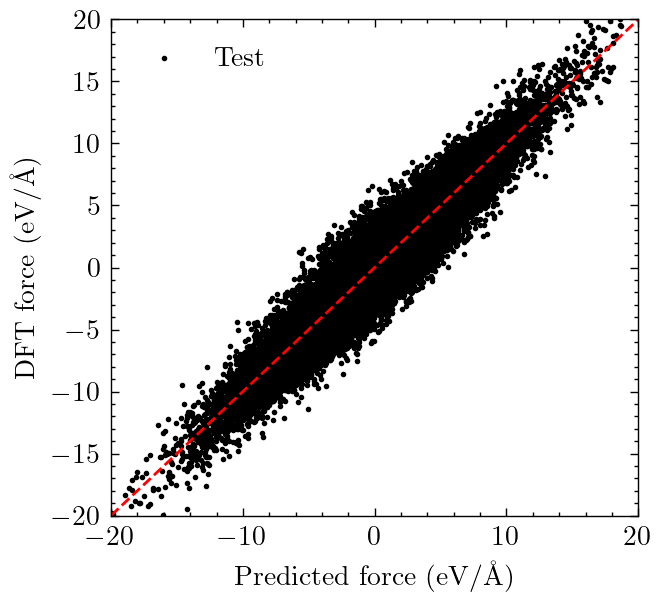

In [15]:
plt.figure(figsize=[3.3,3],dpi=200)

plt.scatter(model_ridge3.predict(Xtest3),ytest3,1,facecolors='k',ec='k',label='Test')
plt.plot([-20,20],[-20,20],'r--')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.legend()
plt.tight_layout()
plt.xlabel('Predicted force (eV/$\mathrm{\AA}$)')
plt.ylabel('DFT force (eV/$\mathrm{\AA}$)')
# plt.savefig('/Volumes/GoogleDrive/My Drive/Research/silica_potential_AIMD/figures/performance.pdf')

In [14]:
from scipy.signal import savgol_filter

In [15]:
buckingham_SiO = np.loadtxt('../BKS_ZBL.6.0.table',skiprows=3,max_rows=7055)
buckingham_OO = np.loadtxt('../BKS_ZBL.6.0.table',skiprows=8+7055,max_rows=7055)
buckingham_SiSi = np.loadtxt('../BKS_ZBL.6.0.table',skiprows=11+2*7055,max_rows=7055)

In [16]:
kcalpermole2ev = 1000*scc.calorie/scc.Avogadro/scc.electron_volt

In [17]:
q_Si = 2.4
q_O = -1.2

fq_SiSi = (1e20/buckingham_SiSi[:,1]**2)*q_Si*q_Si*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
# /1e12*1000/scc.Avogadro/scc.elementary_charge
fq_SiO = (1e20/buckingham_SiO[:,1]**2)*q_Si*q_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
fq_OO = (1e20/buckingham_OO[:,1]**2)*q_O*q_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev

eq_SiSi = (1e10/buckingham_SiSi[:,1])*q_Si*q_Si*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/scc.electron_volt/kcalpermole2ev
eq_SiO = (1e10/buckingham_SiO[:,1])*q_Si*q_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/scc.electron_volt/kcalpermole2ev
eq_OO = (1e10/buckingham_OO[:,1])*q_O*q_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/scc.electron_volt/kcalpermole2ev

In [20]:
# # unit kcal/mol/A
# f_SiSi=model_ridge.coef_[:int(Xtrain.shape[1]/2)]/kcalpermole2ev
# f_SiO = w1/(w1+w2)*(model_ridge.coef_[int(Xtrain.shape[1]/2):]/kcalpermole2ev) + w2/(w1+w2)*(model_ridge2.coef_[:int(Xtrain2.shape[1]/2)]/kcalpermole2ev)
# f_OO = model_ridge2.coef_[int(Xtrain2.shape[1]/2):]/kcalpermole2ev

# f_SiSi1 = model_ridge1.coef_/kcalpermole2ev
# f_SiO1 = model_ridge2.coef_[:int(Xtrain2.shape[1]/2)]/kcalpermole2ev

f_SiSi3 = model_ridge3.coef_[:nrange]/kcalpermole2ev
f_SiO3 = model_ridge3.coef_[nrange:2*nrange]/kcalpermole2ev
f_OO3 = model_ridge3.coef_[2*nrange:]/kcalpermole2ev
# np.savez('FF_ML',R=R,f_SiSi3=f_SiSi3,f_SiO3=f_SiO3,f_OO3=f_OO3)

# no regularization 
f_SiSi4 = model_linear.coef_[:nrange]/kcalpermole2ev
f_SiO4 = model_linear.coef_[nrange:2*nrange]/kcalpermole2ev
f_OO4 = model_linear.coef_[2*nrange:]/kcalpermole2ev

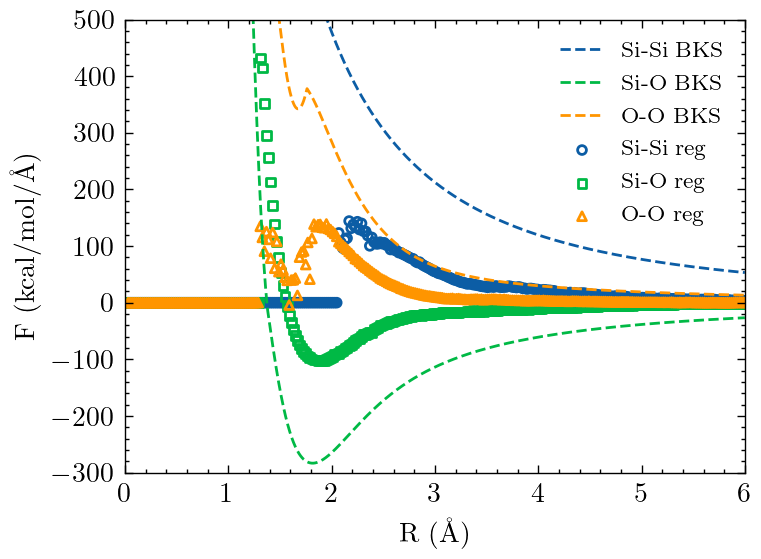

In [23]:
plt.figure(dpi=200,figsize=[4,3])
plt.scatter(R[R<8],f_SiSi3,marker='o',s=10,ec='C0',facecolor='None',label='Si-Si reg')
plt.scatter(R[R<8],f_SiO3,marker='s',s=10,ec='C1',facecolor='None',label='Si-O reg')
plt.scatter(R[R<8],f_OO3,marker='^',s=10,ec='C2',facecolor='None',label='O-O reg')
# plt.plot(R,model_ridge.coef_[int(Xtrain.shape[1]/2):]/kcalpermole2ev,'o',markersize=1,label='Si-O from Si ff')
# plt.plot(R,f_SiO,'o',markersize=1,label='Si-O from O ff')
# plt.plot(R,f_SiSi,'o',markersize=1,label='Si-O from O ff')
# plt.plot(R,f_OO,'ko',markersize=1,label='Si-O from O ff')

# plt.scatter(R[R<8],f_SiSi4,marker='o',s=10,ec='C3',facecolor='None',label='Si-Si non-reg')
# plt.scatter(R[R<8],f_SiO4,marker='s',s=10,ec='C4',facecolor='None',label='Si-O non-reg')
# plt.scatter(R[R<8],f_OO4,marker='^',s=10,ec='C5',facecolor='None',label='O-O non-reg')

# plt.plot(R,(model_ridge2.coef_[:int(Xtrain2.shape[1]/2)]+model_ridge.coef_[int(Xtrain.shape[1]/2):])/2/kcalpermole2ev,'o',markersize=1,label='Si-O ML')

# x = model_ridge2.coef_[int(Xtrain2.shape[1]/2):]
# plt.plot(R[np.abs(x)>0],savgol_filter(x[np.abs(x)>0], 5, 3),'--')

## BKS potential 
# plt.plot(bks_SiO[:,1],bks_SiO[:,3])
plt.plot(buckingham_SiSi[:,1],buckingham_SiSi[:,3]+fq_SiSi,'C0--',label='Si-Si BKS')
plt.plot(buckingham_SiO[:,1],buckingham_SiO[:,3]+fq_SiO,'C1--',label='Si-O BKS')
plt.plot(buckingham_OO[:,1],buckingham_OO[:,3]+fq_OO,'C2--',label='O-O BKS')

# plt.plot(buckingham_SiSi[:,1],fq_SiSi/4,'C0-.',label='Si-Si Coloumb')
# plt.plot(buckingham_SiO[:,1],fq_SiO/4,'C1-.',label='Si-O Coloumb')
# plt.plot(buckingham_OO[:,1],fq_OO/4,'C2-.',label='O-O Coloumb')

# plt.plot(ffnew_SiSi[:,0],ffnew_SiSi[:,2],'C0')
# plt.plot(ffnew_SiO[:,0],ffnew_SiO[:,2],'C1')
# plt.plot(ffnew_OO[:,0],ffnew_OO[:,2],'C2')

plt.ylim(-300,500)
plt.xlim(0,6)
plt.ylabel('F (kcal/mol/$\mathrm{\AA}$)')
plt.xlabel('R ($\mathrm{\AA}$)')
plt.legend(fontsize=8)
# plt.savefig('/Volumes/GoogleDrive/My Drive/Research/silica_potential_AIMD/figures/force.pdf')

# For comparison, shik 

In [66]:
# O-O, O-Si, Si-Si
A = np.array([1120.5,23107.8,2797.9]) # eV
B = np.array([2.893,5.098,4.407]) # A-1
C = np.array([26.1,139.7,0.0]) # eVA6
D = np.array([16800,66,3423204]) # eVA24

q_Si = 1.7755
q_O = -q_Si/2
r_scut = 8
r_lcut = 10

In [85]:
# similar for BKS
A_BKS = np.array([1388.773,18003.757,0.0])
B_BKS = np.array([2.76,4.87318,0])
C_BKS = np.array([175.0,133.538,0])

q_Si_BKS = 2.4
q_O_BKS = -1.2
# r_scut = 5.5
# r_lcut = 10

In [67]:
def F_buckingham_coulomb(r,q1,q2,A,B,C,D):
    return (1e20*q1*q2/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
            + A*B*np.exp(-B*r) /kcalpermole2ev 
            - 6*C/r**7 /kcalpermole2ev + 24*D/r**25 /kcalpermole2ev) 

# Subtract Coulomb interaction from the total force 

In [7]:
SE_sum = []
for iq in np.arange(0,2.6,0.4):
    qtmp_Si = iq 
    qtmp_O = -qtmp_Si/2
    # Si 
    tmp = 1/R**2
    y_force_sub = y_force-X[:,:int(X.shape[1]/2)]@tmp*1e20*qtmp_Si*qtmp_Si*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt \
    -X[:,int(X.shape[1]/2):]@tmp*1e20*qtmp_Si*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt

    # O 
    tmp = 1/R**2
    y_force2_sub = (y_force2-X2[:,:int(X.shape[1]/2)]@tmp*1e20*qtmp_Si*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt 
    -X2[:,int(X.shape[1]/2):]@tmp*1e20*qtmp_O*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt)

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_force_sub,random_state=1,test_size=0.2)
    model_ridge = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,
                                    alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])) # alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
    model_ridge.fit(Xtrain,ytrain)
    # model_lasso = linear_model.LassoCV(cv=10,fit_intercept=True,normalize=False)
    model_ridge.score(Xtest,ytest)
    Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y_force2_sub,random_state=1,test_size=0.2)
    model_ridge2 = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,) # ,alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
    model_ridge2.fit(Xtrain2,ytrain2)
    model_ridge2.score(Xtrain2,ytrain2)
    # squared error 
    SE_sum.append(np.sum((ytest-model_ridge.predict(Xtest))**2) + np.sum((ytest2-model_ridge2.predict(Xtest2))**2))


In [8]:
qtest=np.arange(0,2.6,0.4)
qtest[np.argmin(np.array(SE_sum))]

0.0

Text(0.5, 0, 'q(Si)')

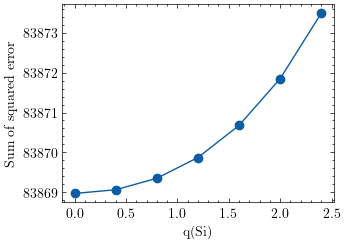

In [15]:
plt.figure(dpi=100)
plt.plot(qtest,SE_sum,'-o')
plt.ylabel('Sum of squared error')
plt.xlabel('q(Si)')

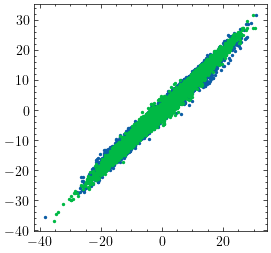

In [20]:
plt.figure(dpi=100,figsize=[3,3])
plt.scatter(ytest,model_ridge.predict(Xtest),2)
plt.scatter(ytest2,model_ridge2.predict(Xtest2),2)

In [30]:
# q=2.4
f_SiSi_2d4 = model_ridge.coef_[:int(X.shape[1]/2)]/kcalpermole2ev+ tmp*1e20*qtmp_Si*qtmp_Si*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
f_SiO_2d4 = 1/2*(model_ridge.coef_[int(X.shape[1]/2):]+model_ridge2.coef_[:int(X.shape[1]/2)])/kcalpermole2ev+ tmp*1e20*qtmp_Si*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
f_OO_2d4 = model_ridge2.coef_[int(X.shape[1]/2):]/kcalpermole2ev+ tmp*1e20*qtmp_O*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev


In [41]:
# q=0 
f_SiSi_0 = model_ridge.coef_[:int(X.shape[1]/2)]/kcalpermole2ev+ tmp*1e20*qtmp_Si*qtmp_Si*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
f_SiO_0 = 1/2*(model_ridge.coef_[int(X.shape[1]/2):]+model_ridge2.coef_[:int(X.shape[1]/2)])/kcalpermole2ev+ tmp*1e20*qtmp_Si*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
f_OO_0 = model_ridge2.coef_[int(X.shape[1]/2):]/kcalpermole2ev+ tmp*1e20*qtmp_O*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev


In [49]:
# q=2
f_SiSi_2 = model_ridge.coef_[:int(X.shape[1]/2)]/kcalpermole2ev+ tmp*1e20*qtmp_Si*qtmp_Si*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
f_SiO_2 = 1/2*(model_ridge.coef_[int(X.shape[1]/2):]+model_ridge2.coef_[:int(X.shape[1]/2)])/kcalpermole2ev+ tmp*1e20*qtmp_Si*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
f_OO_2 = model_ridge2.coef_[int(X.shape[1]/2):]/kcalpermole2ev+ tmp*1e20*qtmp_O*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev


In [98]:
# q=2
f_SiSi_2v2 = model_ridge.coef_[:int(X.shape[1]/2)]/kcalpermole2ev+ tmp*1e20*qtmp_Si*qtmp_Si*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
f_SiO_2v2 = 1/2*(model_ridge.coef_[int(X.shape[1]/2):]+model_ridge2.coef_[:int(X.shape[1]/2)])/kcalpermole2ev+ tmp*1e20*qtmp_Si*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
f_OO_2v2 = model_ridge2.coef_[int(X.shape[1]/2):]/kcalpermole2ev+ tmp*1e20*qtmp_O*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev


(-200.0, 300.0)

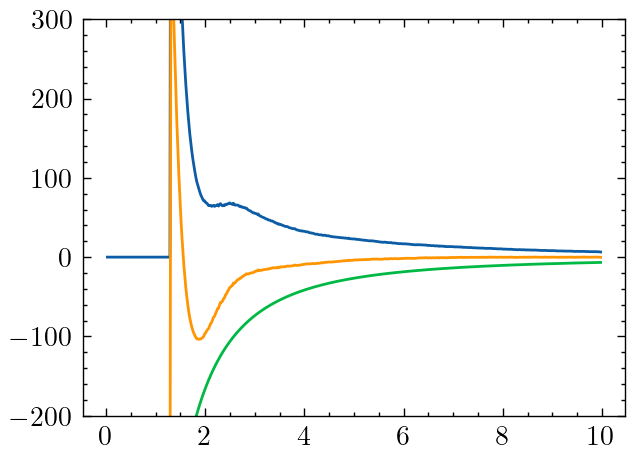

In [77]:
plt.figure(dpi=200)
plt.plot(R,1/2*(model_ridge.coef_[int(X.shape[1]/2):]+model_ridge2.coef_[:int(X.shape[1]/2)])/kcalpermole2ev)
plt.plot(R,tmp*1e20*qtmp_Si*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev)
plt.plot(R,f_SiO_2)
plt.ylim(-200,300)

In [96]:
y_force = y_force1_do_v2.copy()
X = X1_do_v2.copy()
y_force2=y_force2_do_v2.copy()
X2=X2_do_v2.copy()

In [97]:
# q=0
qtmp_Si = 2
qtmp_O = -qtmp_Si/2
# Si 
tmp = 1/R**2
y_force_sub = y_force-X[:,:int(X.shape[1]/2)]@tmp*1e20*qtmp_Si*qtmp_Si*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt \
-X[:,int(X.shape[1]/2):]@tmp*1e20*qtmp_Si*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt

# O 
tmp = 1/R**2
y_force2_sub = (y_force2-X2[:,:int(X.shape[1]/2)]@tmp*1e20*qtmp_Si*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt 
-X2[:,int(X.shape[1]/2):]@tmp*1e20*qtmp_O*qtmp_O*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_force_sub,random_state=1,test_size=0.2)
model_ridge = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,
                                alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])) # alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
model_ridge.fit(Xtrain,ytrain)
# model_lasso = linear_model.LassoCV(cv=10,fit_intercept=True,normalize=False)
model_ridge.score(Xtest,ytest)
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y_force2_sub,random_state=1,test_size=0.2)
model_ridge2 = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,) # ,alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
model_ridge2.fit(Xtrain2,ytrain2)
model_ridge2.score(Xtrain2,ytrain2)

0.9799963201775499

(0.0, 6.0)

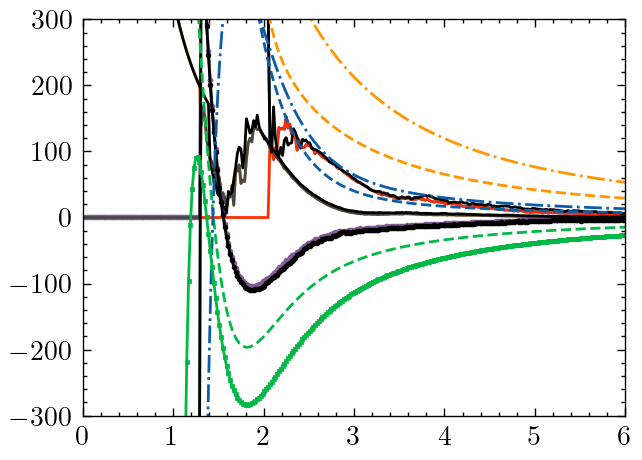

In [100]:
plt.figure(dpi=200)
plt.plot(R,f_SiSi_2)
plt.plot(R,f_SiO_2,'-')
plt.plot(R,f_OO_2)

plt.plot(R,f_SiSi_0,)
plt.plot(R,f_SiO_0,'-o',ms=1)
plt.plot(R,f_OO_0)

plt.plot(R,f_SiSi_2v2,'k')
plt.plot(R,f_SiO_2v2,'-ko',ms=1)
plt.plot(R,f_OO_2v2,'k')

plt.plot(R,F_buckingham_coulomb(R,q_O,q_O,A[0],B[0],C[0],D[0]),'C0--',label='SHIK O-O')
plt.plot(R,F_buckingham_coulomb(R,q_O,q_Si,A[1],B[1],C[1],D[1]),'C1--',label='SHIK Si-O')
plt.plot(R,F_buckingham_coulomb(R,q_Si,q_Si,A[2],B[2],C[2],D[2]),'C2--',label='SHIK Si-Si')

plt.plot(R,F_buckingham_coulomb(R,q_O_BKS,q_O_BKS,A_BKS[0],B_BKS[0],C_BKS[0],0),'C0-.',label='BKS O-O')
plt.plot(R,F_buckingham_coulomb(R,q_O_BKS,q_Si_BKS,A_BKS[1],B_BKS[1],C_BKS[1],0),'C1-s',ms=1,label='BKS Si-O')
plt.plot(R,F_buckingham_coulomb(R,q_Si_BKS,q_Si_BKS,A_BKS[2],B_BKS[2],C_BKS[2],0),'C2-.',label='BKS Si-Si')

# plt.scatter(R,f_SiSi3,marker='o',s=10,ec='C0',facecolor='None',label='Si-Si New')
# plt.scatter(R,f_SiO3,marker='s',s=10,ec='C1',facecolor='None',label='Si-O New')
# plt.scatter(R,f_OO3,marker='^',s=10,ec='C2',facecolor='None',label='O-O New')

plt.ylim(-300,300)
plt.xlim(0,6)

# Fitting the force field with Buckingham 

In [80]:
def ff_form1(r,qq,A,B,C):
    """
    force form, unit = kcal/mol/A
    This form is the same as the BKS potential, qq unit: e2, A unit: eV, B: 1/A, C: eV*A6
    """
    return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
            + A*B*np.exp(-B*r) /kcalpermole2ev 
            - 6*C/r**7 /kcalpermole2ev) # + 4*D*((12)*E**12/r**12/kcalpermole2ev)

In [174]:
def ff_form2(r,A,B):
    """
    force form, unit = kcal/mol/A
    """
    return  A*B*np.exp(-B*r) /kcalpermole2ev 
            

In [203]:
def ff_form2(r,qq):
    """
    force form, unit = kcal/mol/A
    """
    return  1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev
            

In [40]:
# def ff_form1(r,qq,De,a,re):
#     """
#     force form (Morse), unit = kcal/mol/A
    
#     """
#     return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
#             + De*(1-np.exp(-(a*(r-re))))**2   )

In [81]:
def eff_form1(r,qq,A,B,C):
    """
    force form, unit = kcal/mol/A
    This form is the same as the BKS potential, qq unit: e2, A unit: eV, B: 1/A, C: eV*A6
    """
    return (1e10*qq/r*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/scc.electron_volt/kcalpermole2ev 
            + A*np.exp(-B*r) /kcalpermole2ev 
            - C/r**6 /kcalpermole2ev )

In [45]:
# def ff_form2(r,qq,epsilon,sigma):
#     """
#     force form, unit = kcal/mol/A
#     This form is LJ+Coulomb, qq unit: e2, A unit: eV, B: 1/A, C: eV*A6
#     """
#     return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt 
#             + 4*epsilon*((12)*sigma**12/r**12 
#             - 6*sigma**6/r**7) )/kcalpermole2ev

In [82]:
R = R[R<8]

In [125]:
q_Si_list = np.arange(0.4,1.4,0.01)
loss_list = []

for i in range(len(q_Si_list)):
    qf_Si = q_Si_list[i]
    qf_O = -qf_Si/2
    
    cut_test1 = 2.8
    cut_test2 = 5.5
    
    cut_SiSi = 2.4
    xfit = R[(R>cut_SiSi)*(R<cut_test2)]
    yfit=f_SiSi3[(R>cut_SiSi)*(R<cut_test2)]
    params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,1388,3,175],bounds=([qf_Si**2-1e-8,0,0,0],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
#     params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,0,0,0],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
    
    cut_SiO = 1.3
    xfit = R[(R>cut_SiO)*(R<cut_test2)]
    yfit=f_SiO3[(R>cut_SiO)*(R<cut_test2)]
    params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,18000,4.8,133],bounds=([qf_O*qf_Si-1e-8,0,0,0],[qf_O*qf_Si,100000,100000,10000]),maxfev=1000000)[0]
#     params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,0,0,0],maxfev=1000000)[0]
    
    cut_OO = 2.2
    xfit = R[(R>cut_OO)*(R<cut_test2)]
    yfit=f_OO3[(R>cut_OO)*(R<cut_test2)]
    params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,1388,4,300],bounds=([qf_O**2-1e-8,0,0,0],[qf_O**2,100000,10000,10000]),maxfev=1000000)[0]
#     params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,0,0,0],maxfev=1000000)[0]

    # print(params_SiSi,params_SiO,params_OO)
    
    loss = np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(ff_form1(R[(R>cut_test1)*(R<cut_test2)],*params_SiSi)-f_SiSi3[(R>cut_test1)*(R<cut_test2)])**2) + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(ff_form1(R[(R>cut_test1)*(R<cut_test2)],*params_SiO)-f_SiO3[(R>cut_test1)*(R<cut_test2)])**2)*2 + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(ff_form1(R[(R>cut_test1)*(R<cut_test2)],*params_OO)-f_OO3[(R>cut_test1)*(R<cut_test2)])**2)*4
    
    loss_list.append(loss)

In [211]:
# q_Si_list = np.arange(0.2,1,0.01)
# loss_list = []

# for i in range(len(q_Si_list)):
#     qf_Si = q_Si_list[i]
#     qf_O = -qf_Si/2
        
#     cut_test = 6
#     loss = np.sum(R[R>cut_test]**2*(ff_form2(R[R>cut_test],qf_Si**2)-f_SiSi3[R>cut_test])**2) + \
#             np.sum(R[R>cut_test]**2*(ff_form2(R[R>cut_test],qf_Si*qf_O)-f_SiO3[R>cut_test])**2)*2 + \
#             np.sum(R[R>cut_test]**2*(ff_form2(R[R>cut_test],qf_O**2)-f_OO3[R>cut_test])**2)*4
    
#     loss_list.append(loss)

In [126]:
q_Si_list[np.argmin(np.array(loss_list))]

0.8200000000000004

Text(0.5, 0, '$q_\\mathrm{Si}$')

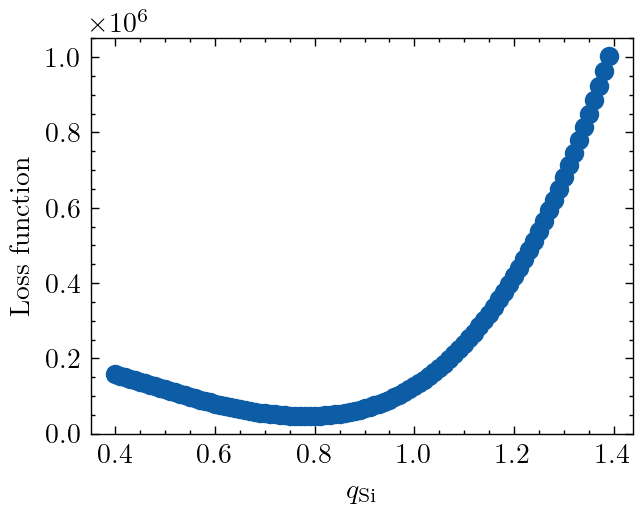

In [35]:
plt.figure(dpi=200)
plt.plot(q_Si_list,loss_list,'-o')
plt.ylabel('Loss function')
plt.xlabel('$q_\mathrm{Si}$')

In [83]:
cut_SiSi = 2.4
cut_SiO = 1.3
cut_OO = 2.2
SR_cut=5.5

In [84]:
qf_Si = 0.82
qf_O = -qf_Si/2

xfit = R[(R>cut_SiSi)*(R<SR_cut)]
yfit=f_SiSi3[(R>cut_SiSi)*(R<SR_cut)]
params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,1388,3,175],bounds=([qf_Si**2-1e-8,0,0,0],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
# params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,-100,1,2],bounds=([qf_Si**2-1e-8,-100000,-100000,-100000],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]


# cut_SiO1=1.5
cut_SiO2=1.3
xfit = R[(R>cut_SiO2)*(R<SR_cut)]
yfit=f_SiO3[(R>cut_SiO2)*(R<SR_cut)]
params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,18000,4.8,133],bounds=([qf_O*qf_Si-1e-8,0,0,0],[qf_O*qf_Si,100000,100000,10000]),maxfev=1000000)[0]
# params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,1000,1,2],bounds=([qf_O*qf_Si-1e-8,-100000,-100000,-100000],[qf_O*qf_Si,100000,100000,10000]),maxfev=1000000)[0]

# xfit = R[(R>cut_SiO1)*(R<cut_SiO2)]
# yfit=f_SiO3[(R>cut_SiO1)*(R<cut_SiO2)]
# params2_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,18000,4.8,133],bounds=([qf_O*qf_Si-1e-8,0,0,0],[qf_O*qf_Si,100000,100000,10000]),maxfev=1000000)[0]

# params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,18000,4.8,133],maxfev=1000000)[0]

xfit = R[(R>cut_OO)*(R<SR_cut)]
yfit=f_OO3[(R>cut_OO)*(R<SR_cut)]
params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,1388,4,300],bounds=([qf_O**2-1e-8,0,0,0],[qf_O**2,100000,10000,10000]),maxfev=1000000)[0]
# params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,-100,1,3],bounds=([qf_O**2-1e-8,-100000,-100000,-100000],[qf_O**2,100000,10000,10000]),maxfev=1000000)[0]


In [106]:
print('{:8f}, {:f}, {:f}'.format(params_OO[1],params_OO[2],params_OO[3]))

1643.222980, 2.959664, 165.554199


In [89]:
print(params_SiSi,'\n',params_SiO,'\n',params_OO)

[  0.6724     302.49797887   1.88324471 226.82652368] 
 [-3.36200000e-01  3.00023761e+04  5.32074026e+00  1.41004247e+02] 
 [1.68100000e-01 1.64322298e+03 2.95966439e+00 1.65554199e+02]


In [85]:
# fitting long-range coulomb: Wolf truncation method

def F_wolf(r,q1,q2):
    return (1e20*q1*q2*(1/r**2-1/8**2)*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev)

# xfit = R[R>5]
# yfit=f_SiSi3[R>5]
# params_SiSi = optimize.curve_fit(ff_form2, xfit, yfit, p0=[1388,3],maxfev=1000000)[0]
# # params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,-100,1,2],bounds=([qf_Si**2-1e-8,-100000,-100000,-100000],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]


# # cut_SiO1=1.5
# # cut_SiO2=1.3
# xfit = R[R>5]
# yfit=f_SiO3[R>5]
# params_SiO = optimize.curve_fit(ff_form2, xfit, yfit, p0=[-18000,4.8],maxfev=1000000)[0]
# # params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,1000,1,2],bounds=([qf_O*qf_Si-1e-8,-100000,-100000,-100000],[qf_O*qf_Si,100000,100000,10000]),maxfev=1000000)[0]

# xfit = R[R>5]
# yfit=f_OO3[R>5]
# params_OO = optimize.curve_fit(ff_form2, xfit, yfit, p0=[1388,4],maxfev=1000000)[0]
# params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,-100,1,3],bounds=([qf_O**2-1e-8,-100000,-100000,-100000],[qf_O**2,100000,10000,10000]),maxfev=1000000)[0]


In [ ]:
plt.figure(dpi=200,figsize=[4,3])
plt.plot(R,f_SiSi3,'o',markersize=2,label='Si-Si')
# plt.plot(R[R>2.4],savgol_filter(f_SiSi3[R>2.4],101,5),label='smooth SiSi')
plt.plot(R,f_SiO3,'o',markersize=2,label='Si-O')
# plt.plot(R[R>1.3],savgol_filter(f_SiO3[R>1.3],101,5),label='smooth SiO')
plt.plot(R,f_OO3,'o',markersize=2,label='O-O')
# plt.plot(R[R>2.2],savgol_filter(f_OO3[R>2.2],101,5),label='smooth OO')
# x = model_ridge2.coef_[int(Xtrain2.shape[1]/2):]
# plt.plot(R[np.abs(x)>0],savgol_filter(x[np.abs(x)>0], 5, 3),'--')

# plt.plot(R,ff_form1(R,*params_SiSi),label='Si-Si fiting')
# plt.plot(R,ff_form1(R,*params_SiO),label='Si-O fiting')
# # plt.plot(R,ff_form1(R,*params2_SiO),label='Si-O fiting')
# plt.plot(R,ff_form1(R,*params_OO),label='O-O fiting')

plt.plot(ffnew_SiSi[:,0],ffnew_SiSi[:,2])
plt.plot(ffnew_SiO[:,0],ffnew_SiO[:,2])
plt.plot(ffnew_OO[:,0],ffnew_OO[:,2])

plt.ylim(-20,30)
# plt.ylim(-150,200)
plt.xlim(0,10)
plt.ylabel('F (kcal/mol/$\mathrm{\AA}$)')
plt.xlabel('R ($\mathrm{\AA}$)')
plt.legend(fontsize=7)

In [48]:
SR_cut = 5.5
gamma = 0.2

In [49]:
# SiO, fitting buckingham+coulomb, + wolf
r=np.arange(0.001,8.001,0.001)
ffnew_SiO=np.zeros((len(r),3))
ffnew_SiO[:,0]=r
rcut = cut_SiO

ffnew_SiO[(r>=rcut)*(r<=SR_cut),2]=ff_form1(r[(r>=rcut)*(r<=SR_cut)],*params_SiO)
ffnew_SiO[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_O,qf_Si)
# cut_tmp = F_wolf(SR_cut,qf_O,qf_Si)
# ffnew_SiO[(r>=rcut)*(r<SR_cut),2]=(ffnew_SiO[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_SiO[r>SR_cut,2][0]
ffnew_SiO[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiO[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

xfit = ffnew_SiO[r>=rcut,0][:5]
yfit = ffnew_SiO[r>=rcut,2][:5]
p1 = np.polyfit(xfit,yfit,1) 
ffnew_SiO[r<rcut,2] = np.polyval(p1,ffnew_SiO[r<rcut,0])

ffnew_SiO[1:,1]=-cumulative_trapezoid(ffnew_SiO[:,2],x=r)
ffnew_SiO[:,1]=ffnew_SiO[:,1]-ffnew_SiO[-1,1]

In [50]:
fleft = -(ffnew_SiO[1:-1,1]-ffnew_SiO[:-2,1])/(ffnew_SiO[1:-1,0]-ffnew_SiO[:-2,0])
fright = -(ffnew_SiO[1:-1,1]-ffnew_SiO[2:,1])/(ffnew_SiO[1:-1,0]-ffnew_SiO[2:,0])

count=0
for i in range(0,7998):
    if (ffnew_SiO[i+1,2]<fleft[i]) and (ffnew_SiO[i+1,2]<fright[i]):
        count=count+1
    if (ffnew_SiO[i+1,2]>fleft[i]) and (ffnew_SiO[i+1,2]>fright[i]):
        count=count+1
print(count)

43


In [51]:
# SiSi, fitting buckingham+coulomb, + wolf
ffnew_SiSi=np.zeros((len(r),3))
ffnew_SiSi[:,0]=r
rcut = 2.5

ffnew_SiSi[(r>=rcut)*(r<=SR_cut),2]=ff_form1(r[(r>=rcut)*(r<=SR_cut)],*params_SiSi)
ffnew_SiSi[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_Si,qf_Si)
# cut_tmp = F_wolf(SR_cut,qf_Si,qf_Si)
# ffnew_SiSi[(r>=rcut)*(r<SR_cut),2]=(ffnew_SiSi[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_SiSi[r>SR_cut,2][0]
ffnew_SiSi[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiSi[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

slope_tmp = -200
tmp = ffnew_SiSi[r>=rcut,2][0] - slope_tmp*rcut
p1 = np.array([slope_tmp,tmp])
ffnew_SiSi[r<rcut,2] = np.polyval(p1,ffnew_SiSi[r<rcut,0])

ffnew_SiSi[1:,1]=-cumulative_trapezoid(ffnew_SiSi[:,2],x=r)
ffnew_SiSi[:,1]=ffnew_SiSi[:,1]-ffnew_SiSi[-1,1]

In [52]:
# OO, fitting buckingham+coulomb, + wolf
ffnew_OO=np.zeros((len(r),3))
ffnew_OO[:,0]=r
rcut = cut_OO

ffnew_OO[(r>=rcut)*(r<=SR_cut),2]=ff_form1(r[(r>=rcut)*(r<=SR_cut)],*params_OO)
ffnew_OO[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_O,qf_O)
# cut_tmp = F_wolf(SR_cut,qf_O,qf_O)
# ffnew_OO[(r>=rcut)*(r<SR_cut),2]=(ffnew_OO[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_OO[r>SR_cut,2][0]
ffnew_OO[(r>=rcut)*(r<=SR_cut),2]=(ffnew_OO[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

slope_tmp = -200
tmp = ffnew_OO[r>=rcut,2][0] - slope_tmp*rcut
p1 = np.array([slope_tmp,tmp])
ffnew_OO[r<rcut,2] = np.polyval(p1,ffnew_OO[r<rcut,0])

ffnew_OO[1:,1]=-cumulative_trapezoid(ffnew_OO[:,2],x=r)
ffnew_OO[:,1]=ffnew_OO[:,1]-ffnew_OO[-1,1]

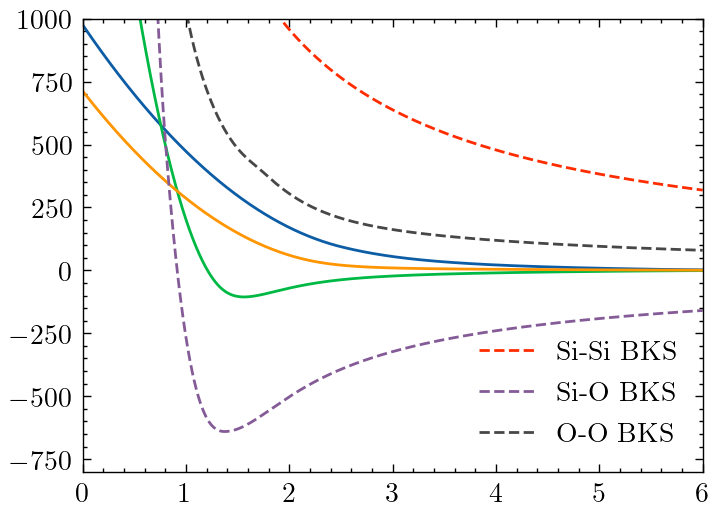

In [92]:
plt.figure(dpi=200,figsize=[4,3])
plt.plot(ffnew_SiSi[:,0],ffnew_SiSi[:,1])
plt.plot(ffnew_SiO[:,0],ffnew_SiO[:,1])
plt.plot(ffnew_OO[:,0],ffnew_OO[:,1])

plt.plot(buckingham_SiSi[:,1],buckingham_SiSi[:,2]+eq_SiSi,'--',label='Si-Si BKS')
plt.plot(buckingham_SiO[:,1],buckingham_SiO[:,2]+eq_SiO,'--',label='Si-O BKS')
plt.plot(buckingham_OO[:,1],buckingham_OO[:,2]+eq_OO,'--',label='O-O BKS')

plt.ylim(-800,1000)
plt.xlim(0,6)
plt.legend()

# Print to lammps table 

In [303]:
# potSiO = np.vstack((R,ESiO,fSiO_m)).transpose()
# potSiSi = np.vstack((R,ESiSi,fSiSi_m)).transpose()
# potOO = np.vstack((R,EOO,fOO_m)).transpose()

# potSiO_lmp = potSiO.copy()
# potSiO_lmp[:,1] = potSiO_lmp[:,1]/scc.calorie
# potSiO_lmp[:,2] = potSiO_lmp[:,2]/scc.calorie/10

# potSiSi_lmp = potSiSi.copy()
# potSiSi_lmp[:,1] = potSiSi_lmp[:,1]/scc.calorie
# potSiSi_lmp[:,2] = potSiSi_lmp[:,2]/scc.calorie/10

# potOO_lmp = potOO.copy()
# potOO_lmp[:,1] = potOO_lmp[:,1]/scc.calorie
# potOO_lmp[:,2] = potOO_lmp[:,2]/scc.calorie/10

In [142]:
cutoff=8

f=open('ff_fittingc8.table','w')
# f.write('# DATE: 2021-09-20  UNITS: real \n')
f.write('# potential for silica, (q_Si={}, SR_cut={}) \n'.format(qf_Si,SR_cut))

f.write('SiO\n')
f.write('N {} R   0.001  {}\n'.format(int(cutoff*1000),cutoff))
f.write('\n')
for i in range(int(cutoff*1000)):
    f.write('   {0:5d}      {1:12.8f}{2:21.12e}{3:21.12e}\n'.format(i+1,ffnew_SiO[i,0],ffnew_SiO[i,1],ffnew_SiO[i,2]))


f.write('\nOO\n')
f.write('N {} R   0.001  {}\n'.format(int(cutoff*1000),cutoff))
f.write('\n')
for i in range(int(cutoff*1000)):
    f.write('   {0:5d}      {1:12.8f}{2:21.12e}{3:21.12e}\n'.format(i+1,ffnew_OO[i,0],ffnew_OO[i,1],ffnew_OO[i,2]))

f.write('\nSiSi\n')
f.write('N {} R   0.001  {}\n'.format(int(cutoff*1000),cutoff))
f.write('\n')
for i in range(int(cutoff*1000)):
    f.write('   {0:5d}      {1:12.8f}{2:21.12e}{3:21.12e}\n'.format(i+1,ffnew_SiSi[i,0],ffnew_SiSi[i,1],ffnew_SiSi[i,2]))
f.close()

In [231]:
cutoff=8
mdegree=1

f=open('ff_fittingc8_full.table','w')
# f.write('# DATE: 2021-09-20  UNITS: real \n')
f.write('# potential for silica, (q_Si={}, SR_cut={}) \n'.format(qf_Si,SR_cut))

f.write('SiO\n')
f.write('N {} R   0.001  {}\n'.format(ffnew_SiO.shape[0],cutoff))
f.write('\n')
for i in range(ffnew_SiO.shape[0]):
    f.write('   {0:5d}      {1:12.8f}  {2:24.15f}  {3:24.15f}\n'.format(i+1,ffnew_SiO[i*mdegree,0],ffnew_SiO[i*mdegree,1],ffnew_SiO[i*mdegree,2]))


f.write('\nOO\n')
f.write('N {} R   0.001  {}\n'.format(ffnew_SiO.shape[0],cutoff))
f.write('\n')
for i in range(ffnew_SiO.shape[0]):
    f.write('   {0:5d}      {1:12.8f}  {2:24.15f}  {3:24.15f}\n'.format(i+1,ffnew_OO[i*mdegree,0],ffnew_OO[i*mdegree,1],ffnew_OO[i*mdegree,2]))

f.write('\nSiSi\n')
f.write('N {} R   0.001  {}\n'.format(ffnew_SiO.shape[0],cutoff))
f.write('\n')
for i in range(ffnew_SiO.shape[0]):
    f.write('   {0:5d}      {1:12.8f}  {2:24.15f}  {3:24.15f}\n'.format(i+1,ffnew_SiSi[i*mdegree,0],ffnew_SiSi[i*mdegree,1],ffnew_SiSi[i*mdegree,2]))
f.close()

In [121]:
# Gromacs?

In [74]:
f1=open('fitting_Si_Si.xvg','w')
f1.write('#Force, SiSi\n')
f1.write('# 0.00 1\n')
f1.write('#\n')
f1.write('   {0:21.12e}{1:21.12e}{2:21.12e}{3:21.12e}{4:21.12e}{5:21.12e}{6:21.12e}\n'.format(0,0,0,ffnew_SiSi[0,1]*scc.calorie,ffnew_SiSi[0,2]*scc.calorie*10,0,0))
for i in range(ffnew_SiSi.shape[0]):
    f1.write('   {0:21.12e}{1:21.12e}{2:21.12e}{3:21.12e}{4:21.12e}{5:21.12e}{6:21.12e}\n'.format(ffnew_SiSi[i,0]/10,0,0,ffnew_SiSi[i,1]*scc.calorie,ffnew_SiSi[i,2]*scc.calorie*10,0,0))
r_more  = np.arange(0.8001,1,0.0001)
for i in range(len(r_more)):
    f1.write('   {0:21.12e}{1:21.12e}{2:21.12e}{3:21.12e}{4:21.12e}{5:21.12e}{6:21.12e}\n'.format(r_more[i],0,0,0,0,0,0))
f1.close()

In [75]:
f1=open('fitting_Si_O.xvg','w')
f1.write('#Force, SiSi\n')
f1.write('# 0.00 1\n')
f1.write('#\n')
f1.write('   {0:21.12e}{1:21.12e}{2:21.12e}{3:21.12e}{4:21.12e}{5:21.12e}{6:21.12e}\n'.format(0,0,0,ffnew_SiO[0,1]*scc.calorie,ffnew_SiO[0,2]*scc.calorie*10,0,0))

for i in range(ffnew_SiO.shape[0]):
    f1.write('   {0:21.12e}{1:21.12e}{2:21.12e}{3:21.12e}{4:21.12e}{5:21.12e}{6:21.12e}\n'.format(ffnew_SiO[i,0]/10,0,0,ffnew_SiO[i,1]*scc.calorie,ffnew_SiO[i,2]*scc.calorie*10,0,0))
for i in range(len(r_more)):
    f1.write('   {0:21.12e}{1:21.12e}{2:21.12e}{3:21.12e}{4:21.12e}{5:21.12e}{6:21.12e}\n'.format(r_more[i],0,0,0,0,0,0))
f1.close()

In [76]:
f1=open('fitting_O_O.xvg','w')
f1.write('#Force, SiSi\n')
f1.write('# 0.00 1\n')
f1.write('#\n')
f1.write('   {0:21.12e}{1:21.12e}{2:21.12e}{3:21.12e}{4:21.12e}{5:21.12e}{6:21.12e}\n'.format(0,0,0,ffnew_OO[0,1]*scc.calorie,ffnew_OO[0,2]*scc.calorie*10,0,0))

for i in range(ffnew_OO.shape[0]):
    f1.write('   {0:21.12e}{1:21.12e}{2:21.12e}{3:21.12e}{4:21.12e}{5:21.12e}{6:21.12e}\n'.format(ffnew_OO[i,0]/10,0,0,ffnew_OO[i,1]*scc.calorie,ffnew_OO[i,2]*scc.calorie*10,0,0))
for i in range(len(r_more)):
    f1.write('   {0:21.12e}{1:21.12e}{2:21.12e}{3:21.12e}{4:21.12e}{5:21.12e}{6:21.12e}\n'.format(r_more[i],0,0,0,0,0,0))
f1.close()